## Parse and visualize Neural Network results

After training a simple neural network using Pytorch, I ran the resulting model against some of the heuristic AI play styles.

The neural network was trained on data obtained exclusively from the MTAG play style.  It should thus play more or less identically to the MTAG.  To confirm this, I re-ran the scenarios in the heuristic tournament results notebook.  The neural network is compared to the LAG, TAG, MTAG, and random play styles.

In [1]:
# Imports
###############################################################################
# Standard system imports
import ctypes
from os import listdir
from os.path import isfile, join
# Related third party imports
import numpy as np
import pandas as pd
import seaborn as sns
# Local application/library specific imports

sns.set_style("darkgrid")

In [2]:
# Classes used to contain data
###############################################################################
class TournamentSummary(ctypes.Structure):
    """Creates a tournament_summary struct."""

    _fields_ = [('tournament_number', ctypes.c_int),
                ('random_seed', ctypes.c_int),
                ('initial_player_count', ctypes.c_int),
                ('player_ai_types', ctypes.POINTER(ctypes.c_int)),
                ('finishing_order', ctypes.POINTER(ctypes.c_int)),
                ('game_eliminated', ctypes.POINTER(ctypes.c_int)),
                ('num_games', ctypes.c_size_t)]


class PythonTournamentSummary:
    """Creates a tournament summary for parsing in Python."""

    def __init__(self, th, player_ai_types, finishing_order, game_eliminated):
        self.tournament_number = th.tournament_number
        self.random_seed = th.random_seed
        self.initial_player_count = th.initial_player_count
        self.player_ai_types = player_ai_types
        self.finishing_order = finishing_order
        self.game_eliminated = game_eliminated
        self.num_games = th.num_games



In [3]:
# Initialize and test C shared library
###############################################################################
# Location of C shared library
c_lib = ctypes.CDLL("../../Cpp/lib/lib_deepshark.so")
# %% Set data types of test C function's arguments and return value
add_ints = c_lib.add_ints
add_ints.argtypes = [ctypes.c_int, ctypes.c_int]
add_ints.restype = ctypes.c_int  # C function returns integer
# Test C function
result = add_ints(4, 5)
print(result)

9


In [4]:
# Initalize C function to get tournament results
###############################################################################
tourn_summary = c_lib.get_tournament_summary
tourn_summary.argtypes = [ctypes.POINTER(
    TournamentSummary), ctypes.POINTER(ctypes.c_char)]
tourn_summary.restype = None

In [5]:
# Function to parse and store tournament results
###############################################################################
def summarize_tournament_results(tourn_directory):
    tourn_files = [join(tourn_directory, f) for f in listdir(
        tourn_directory) if isfile(join(tourn_directory, f))]
    summary_list = list()
    for tourn in tourn_files:
        # Encode filename as a pointer to array of chars
        b_fn = tourn.encode("utf-8")  # create byte objects from the strings
        filename = ctypes.c_char_p(b_fn)
        # Instantiate struct to contain summary results
        th = TournamentSummary()
        th_ptr = ctypes.pointer(th)
        
        # Create NumPy arrays to store finishing order and game eliminated arrays
        player_ai_types_arr = np.zeros(10, dtype=np.intc)
        player_ai_types_ptr = player_ai_types_arr.ctypes.data_as(
            ctypes.POINTER(ctypes.c_int))
        th.player_ai_types = player_ai_types_ptr
        
        finishing_order_arr = np.zeros(10, dtype=np.intc)
        finishing_order_ptr = finishing_order_arr.ctypes.data_as(
            ctypes.POINTER(ctypes.c_int))
        th.finishing_order = finishing_order_ptr

        game_eliminated_arr = np.zeros(10, dtype=np.intc)
        game_eliminated_ptr = game_eliminated_arr.ctypes.data_as(
            ctypes.POINTER(ctypes.c_int))
        th.game_eliminated = game_eliminated_ptr
        
        # Pass pointer to struct and filename to C function
        tourn_summary(th_ptr, filename)
        # Transfer results to Python class and append to list
        pth = PythonTournamentSummary(th, player_ai_types_arr, finishing_order_arr, game_eliminated_arr)
        summary_list.append(pth)
    return summary_list

## NN vs. LAG

First, let's compare the performance of the neural network player to the loose-aggressive (LAG) player by simulating 100 ten-player tournaments.  Half the players in each tournament will be the neural network (NN) and the other half LAGs.  I simulated the tournaments and recorded the data to disk using the *generate_training_data.py* contained in `src/deepshark`.  For some reason running this code in a Jupyter notebook causes the Jupyter kernel to crash and restart, but it runs without issue from a Python script.

In [6]:
# Specify directory containing recorded tournaments and parse data
tourn_directory = "../../../recorded_games/2024-01-10/nn_lag/"  # Must update this field
summary_list = summarize_tournament_results(tourn_directory)

In [7]:
# Post-process tournament results
###############################################################################
lag_count = 0
nn_count = 0

lag_game_count = []
nn_game_count = []

for summ in summary_list:
    tourn_winner = summ.finishing_order[summ.initial_player_count-1]
    if summ.player_ai_types[tourn_winner] == 6:
        nn_count += 1
        nn_game_count.append(summ.game_eliminated[summ.initial_player_count-1])
    elif summ.player_ai_types[tourn_winner] == 4:
        lag_count += 1
        lag_game_count.append(summ.game_eliminated[summ.initial_player_count-1])

print(f"LAG tournament win count = {lag_count}")
print(f"NN tournament win count = {nn_count}")

print(f"LAG average game count per tournament = {np.average(lag_game_count)}")
print(f"NN average game count per tournament = {np.average(nn_game_count)}")

LAG tournament win count = 55
NN tournament win count = 45
LAG average game count per tournament = 150.83636363636364
NN average game count per tournament = 178.15555555555557


In [8]:
nn_finishing_order_arr = np.zeros(10)
lag_finishing_order_arr = np.zeros(10)

for summ in summary_list:
    for idx, plyr in enumerate(summ.finishing_order):
        if summ.player_ai_types[plyr] == 6: # NN
            nn_finishing_order_arr[idx] += 1
        elif summ.player_ai_types[plyr] == 4: # LAG
            lag_finishing_order_arr[idx] += 1

cnt = summ.initial_player_count
nn_lag_df = pd.DataFrame(
    {
        "Result": [cnt-idx for idx in range(cnt)],
        "NN": [x for x in nn_finishing_order_arr],
        "LAG": [x for x in lag_finishing_order_arr]
    }
)

nn_lag_df

,Result,NN,LAG
0,10,49.0,51.0
1,9,50.0,50.0
2,8,48.0,52.0
3,7,52.0,48.0
4,6,50.0,50.0
5,5,52.0,48.0
6,4,50.0,50.0
7,3,46.0,54.0
8,2,58.0,42.0
9,1,45.0,55.0


<Axes: xlabel='Result'>

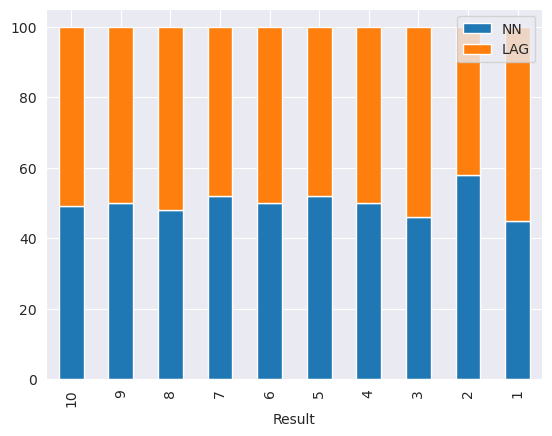

In [9]:
nn_lag_df.set_index("Result").plot(kind='bar', stacked=True)

### Tournament Results: NN vs. LAG

The neural network and the LAG players have almost identical results.  The LAG player does have a slight advantage in tournament wins.  The MTAG player that the neural network was trained on did better versus the LAG in the early rounds, and had a very slight advantage in tournament wins (52 vs. 48) over the LAG.  It is encouraging to see that the neural network has roughly comparable results to the MTAG.

## NN vs. TAG

Next, I performed the same scenario but with 5 NNs versus 5 TAGs.

In [10]:
# Specify directory containing recorded tournaments and parse data
tourn_directory = "../../../recorded_games/2024-01-10/nn_tag/"  # Must update this field
summary_list = summarize_tournament_results(tourn_directory)

In [11]:
# Post-process tournament results
###############################################################################
nn_finishing_order_arr = np.zeros(10)
tag_finishing_order_arr = np.zeros(10)

for summ in summary_list:
    for idx, plyr in enumerate(summ.finishing_order):
        if summ.player_ai_types[plyr] == 6: # NN
            nn_finishing_order_arr[idx] += 1
        elif summ.player_ai_types[plyr] == 3: # TAG
            tag_finishing_order_arr[idx] += 1

print(nn_finishing_order_arr)
print(tag_finishing_order_arr)

[72. 74. 72. 50. 41. 29. 34. 35. 34. 59.]
[28. 26. 28. 50. 59. 71. 66. 65. 66. 41.]


In [12]:
cnt = summ.initial_player_count
nn_tag_df = pd.DataFrame(
    {
        "Result": [cnt-idx for idx in range(cnt)],
        "NN": [x for x in nn_finishing_order_arr],
        "TAG": [x for x in tag_finishing_order_arr]
    }
)
nn_tag_df

,Result,NN,TAG
0,10,72.0,28.0
1,9,74.0,26.0
2,8,72.0,28.0
3,7,50.0,50.0
4,6,41.0,59.0
5,5,29.0,71.0
6,4,34.0,66.0
7,3,35.0,65.0
8,2,34.0,66.0
9,1,59.0,41.0


<Axes: xlabel='Result'>

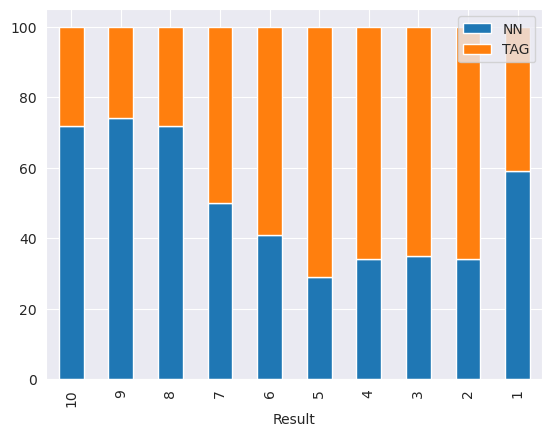

In [13]:
nn_tag_df.set_index("Result").plot(kind='bar', stacked=True)

### NN vs. TAG Results

The TAG has a distinct advantage in the early game, probably because the neural network learned to play a bit looser from the late-game MTAG data.  However, the neural network won significantly more tournaments (59 vs. 41) which is very close to the MTAG vs. TAG results of 62 vs. 38.  This again demonstrates that the neural network learned the MTAG play style well.

## NN vs. MTAG

Finally, the neural network will play against the MTAG - the play style that it was trained on.  My expectation at this point is that the results should be fairly even, with the MTAG having a slight edge.

In [14]:
# Specify directory containing recorded tournaments and parse data
tourn_directory = "../../../recorded_games/2024-01-10/nn_mtag/"  # Must update this field
summary_list = summarize_tournament_results(tourn_directory)

In [15]:
# Post-process tournament results
###############################################################################
mtag_finishing_order_arr = np.zeros(10)
nn_finishing_order_arr = np.zeros(10)

for summ in summary_list:
    for idx, plyr in enumerate(summ.finishing_order):
        if summ.player_ai_types[plyr] == 5: # MTAG
            mtag_finishing_order_arr[idx] += 1
        elif summ.player_ai_types[plyr] == 6: # NN
            nn_finishing_order_arr[idx] += 1

print(mtag_finishing_order_arr)
print(nn_finishing_order_arr)

[28. 26. 28. 50. 59. 71. 66. 64. 54. 54.]
[72. 74. 72. 50. 41. 29. 34. 36. 46. 46.]


In [16]:
cnt = summ.initial_player_count
mtag_vs_nn_df = pd.DataFrame(
    {
        "Result": [cnt-idx for idx in range(cnt)],
        "MTAG": [x for x in mtag_finishing_order_arr],
        "NN": [x for x in nn_finishing_order_arr]
    }
)
mtag_vs_nn_df

,Result,MTAG,NN
0,10,28.0,72.0
1,9,26.0,74.0
2,8,28.0,72.0
3,7,50.0,50.0
4,6,59.0,41.0
5,5,71.0,29.0
6,4,66.0,34.0
7,3,64.0,36.0
8,2,54.0,46.0
9,1,54.0,46.0


<Axes: xlabel='Result'>

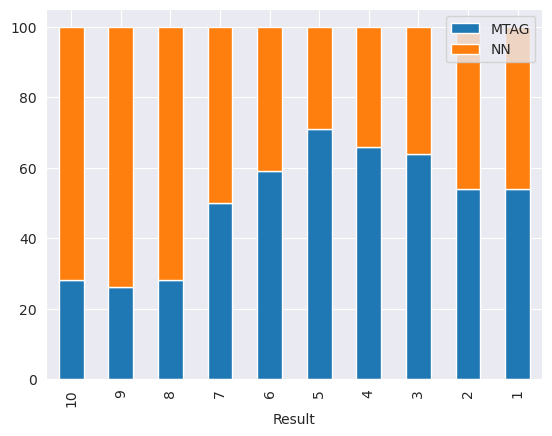

In [17]:
mtag_vs_nn_df.set_index("Result").plot(kind='bar', stacked=True)

### NN vs. MTAG Results

The MTAG player had better performance in the early game, which makes sense given this is the same pattern as in the NN vs. Tag games.  The neural network seems to have learned a slightly looser play style, and so is punished earlier in the tournament.  However, the tournament wins are quite close (54 MTAG vs. 46 NN) as would be expected since the neural network's play style is close to identical to the MTAG.

### NN vs. Random Players

And since I had the MTAG play against random players in the previous experiments, I had the neural network try its hand against the random players as well.

In [18]:
# Specify directory containing recorded tournaments and parse data
tourn_directory = "../../../recorded_games/2024-01-10/nn_random/"  # Must update this field
summary_list = summarize_tournament_results(tourn_directory)

In [19]:
# Post-process tournament results
###############################################################################
random_count = 0
nn_count = 0

random_game_count = []
nn_game_count = []

for summ in summary_list:
    tourn_winner = summ.finishing_order[summ.initial_player_count-1]
    if summ.player_ai_types[tourn_winner] == 6:
        nn_count += 1
        nn_game_count.append(summ.game_eliminated[summ.initial_player_count-1])
    elif summ.player_ai_types[tourn_winner] == 0:
        random_count += 1
        random_game_count.append(summ.game_eliminated[summ.initial_player_count-1])

print(f"Random tournament win count = {random_count}")
print(f"NN tournament win count = {nn_count}")

print(f"Random average game count per tournament = {np.average(random_game_count)}")
print(f"NN average game count per tournament = {np.average(nn_game_count)}")

Random tournament win count = 18
NN tournament win count = 82
Random average game count per tournament = 87.94444444444444
NN average game count per tournament = 180.0487804878049


In [20]:
nn_finishing_order_arr = np.zeros(10)
random_finishing_order_arr = np.zeros(10)

for summ in summary_list:
    for idx, plyr in enumerate(summ.finishing_order):
        if summ.player_ai_types[plyr] == 6: # NN
            nn_finishing_order_arr[idx] += 1
        elif summ.player_ai_types[plyr] == 0: # Random
            random_finishing_order_arr[idx] += 1

cnt = summ.initial_player_count
nn_random_df = pd.DataFrame(
    {
        "Result": [cnt-idx for idx in range(cnt)],
        "NN": [x for x in nn_finishing_order_arr],
        "Random": [x for x in random_finishing_order_arr]
    }
)

nn_random_df

,Result,NN,Random
0,10,6.0,94.0
1,9,2.0,98.0
2,8,4.0,96.0
3,7,13.0,87.0
4,6,59.0,41.0
5,5,71.0,29.0
6,4,78.0,22.0
7,3,90.0,10.0
8,2,95.0,5.0
9,1,82.0,18.0


<Axes: xlabel='Result'>

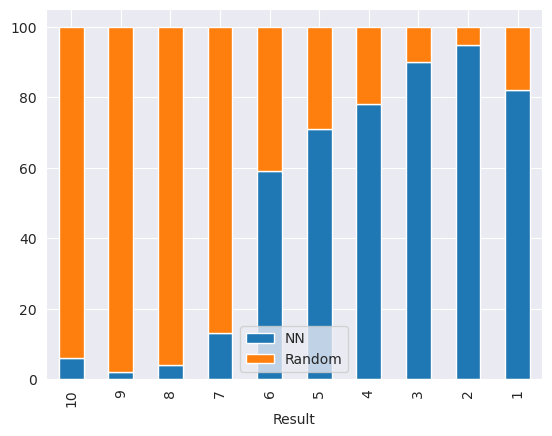

In [21]:
nn_random_df.set_index("Result").plot(kind='bar', stacked=True)

### NN vs. Random Players Results

It wasn't a complete shut-out in the early game like it was for the MTAG players, but still the neural network convincingly trounced the random players.  The final tournament wins are similar to the MTAG, and probably for similar reasons - the random players fed each other an enormous amount of chips.

## Conclusion

The goal of this project was to learn how to implement a C++ game environment that could be called from Python, and that could use models trained in PyTorch to represent the agent.  This lays the ground work for a much more computationally efficient deep reinforcement learning workflow.  Again, the game of Texas Hold 'Em is a somewhat trivial application of this approach, and does not warrant the time and effort to further train an agent using reinforcement learning.  That time would be better spent applying this workflow to a more significant RL task.